# Import Statements

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')
import os

import geodata
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#packages that requires users to install externally
import pickle
import pyproj
from pyproj import Proj
from functools import partial
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import transform as transform
import statsmodels.api as sm
import cartopy.io.shapereader as shpreader

import geopandas as gpd
import geoplot
import seaborn as sns
import plotly.graph_objects as go

# Load from pickle

In [2]:
os.chdir('../data/pickle')

# load from pickle before first run
file = open("districts.pickle",'rb')
districts = pickle.load(file)
file.close()

# state shapes
file = open("states.pickle",'rb')
states = pickle.load(file)
file.close()

# includes LCOE
file = open("xarray_ds_wind.pickle",'rb')
xarray_ds_wind = pickle.load(file)
file.close()
file = open("xarray_ds_solar.pickle",'rb')
xarray_ds_solar = pickle.load(file)
file.close()

# renewable energy targets
# TERI
file = open("wind_t_30.pickle",'rb')
wind_t_30 = pickle.load(file)
file.close()
file = open("solar_t_30.pickle",'rb')
solar_t_30 = pickle.load(file)
file.close()

# NREL
file = open("wind_t_47.pickle",'rb')
wind_t_47 = pickle.load(file)
file.close()
file = open("solar_t_47.pickle",'rb')
solar_t_47 = pickle.load(file)
file.close()

# Download India 2018 ERA5 Hourly Weather Data

In [ ]:
DS_hourly = geodata.Dataset(module="era5",
                            weather_data_config = "wind_solar_hourly",
                            bounds=[37, 68, 6, 98],
                            years=slice(2018, 2018),
                            months=slice(1,12))

if DS_hourly.prepared == False:
	DS_hourly.get_data()

# Create Cutout

In [ ]:
## CUTOUT
cutout = geodata.Cutout(name = "india-2018-era5-wind-solar-hourly",
                        module = "era5",
                        weather_data_config = "wind_solar_hourly",
                        xs = slice(68, 98),
                        ys = slice(6, 37),
                        years=slice(2018, 2018),
                        months=slice(1,12))

cutout.prepare()

# Import Coal Plant / Mine Data

### Importing data from Global Coal Plant Tracker
- July 2020: https://bit.ly/2Cz1Q82
- July 2021 Update: https://bit.ly/3ec60To

In [3]:
os.chdir('../tables')

In [4]:
plants = pd.read_csv("Global-Coal-Plant-Tracker-Jan-2022.csv", encoding="ISO-8859-1")
plants = plants[plants['Country'] == 'India']
plants = plants[plants['Latitude'].isna() == False]
plants = plants[plants['Longitude'].isna() == False]
plants = plants[plants['Status'].isin(['operating'])] 
# 'announced', 'cancelled', 'construction', 'permitted', 'pre-permit', 'retired', 'shelved'])]
plants = plants.drop_duplicates('ParentID')
plants = plants[['Plant', 'Subnational unit (province, state)', 'Status', 'Latitude', 'Longitude', 
                 'Capacity (MW)', 'Annual CO2 (million tonnes / annum)', 'Year']]
plants = plants.rename(columns={'Subnational unit (province, state)': 'State', 'Year': 'Plant Age'})
plants['Capacity (MW)'] = plants['Capacity (MW)'].astype(float)
plants['Plant Age'] = plants['Plant Age'].apply(lambda x: 2021 - float(x))
plants

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Plant,State,Status,Latitude,Longitude,Capacity (MW),Annual CO2 (million tonnes / annum),Plant Age
508,Balaji Cement power station,Andhra Pradesh,operating,16.283333,81.216667,35.0,0.2,12.0
509,Bander power station,Andhra Pradesh,operating,14.351195,80.143086,660.0,2.5,6.0
511,Bhadradri power station,Telangana,operating,18.027488,80.735645,270.0,1.3,1.0
515,Dr Narla Tata Rao power station,Andhra Pradesh,operating,16.598490,80.536585,210.0,1.2,42.0
522,East Godavari Mill power station,Andhra Pradesh,operating,17.300117,82.614386,34.0,0.2,15.0
...,...,...,...,...,...,...,...,...
12407,Anpara power station,Uttar Pradesh,operating,24.202043,82.789128,210.0,1.2,35.0
12428,Barkhera Ipp power station,Uttar Pradesh,operating,28.550000,80.100000,45.0,0.2,10.0
12486,Meja Thermal Power Project,Uttar Pradesh,operating,25.145867,81.940096,660.0,2.5,3.0
12795,Bakreswar Thermal Power Station,West Bengal,operating,23.829220,87.451034,210.0,1.2,22.0


### Importing data from Global Coal Mine Tracker
- July 2020: https://drive.google.com/file/d/1j0zVllXW6Ei9L2mDiqOonsH9JlQe5DWQ/view?usp=sharing
- July 2021 Update: https://www.dropbox.com/s/yp82wpf3juqe3dk/Global%20Coal%20Mine%20Tracker%20%28June%202021%29.xlsx?dl=0

In [5]:
mines = pd.read_csv("pai_coal_mines.csv", encoding="ISO-8859-1")
mines.columns = ['MineID', 'State', 'District', 'Name',
                 'Coal/ Lignite Production (MT) (2019-2020)', 'Owner', 
                 'Coal/Lignite', 'Govt Owned/Private', 'Type', 
                 'Latitude', 'Longitude', 'Source', 'Accuracy', 
                 'Unnamed']
# mines = mines[mines['Country'] == 'India']
# mines = mines[mines['Status'] == 'Operating'] # 'Proposed'
mines = mines[mines['Latitude'].isna() == False]
mines = mines[mines['Longitude'].isna() == False]
# mines = mines.drop_duplicates('Mine ID') 
# mines = mines[['Mine Name', 'Status', 'Status Detail', 'State, Province', 'Coal Output (Annual, Mt)', 'Mine Type', 
#                'Latitude', 'Longitude', 'Opening Year']]
# mines = mines[mines['Opening Year'] != 'TBD']
# mines['Mine Age'] = mines['Opening Year'].apply(lambda x: 2021 - float(x))
# mines = mines.drop(columns=['Opening Year'])
mines

,MineID,State,District,Name,Coal/ Lignite Production (MT) (2019-2020),Owner,Coal/Lignite,Govt Owned/Private,Type,Latitude,Longitude,Source,Accuracy,Unnamed
0,1,West Bengal,Paschim Bardhaman,Ningah Colliery,0.010000,ECL,Coal,G,UG,23.6743,87.0333,Google Maps: https://www.google.com/maps/place...,Exact,NaN
1,2,West Bengal,Paschim Bardhaman,Jhanjhara Project Colly,3.500000,ECL,Coal,G,UG,23.6680,87.2963,Google Maps: https://www.google.ca/maps/place/...,Exact,NaN
2,3,West Bengal,Paschim Bardhaman,MAOHUSUDANPUR 7 PIT &\nINCLINE,0.040000,ECL,Coal,G,UG,23.6338,87.2037,Google Maps: https://www.google.com/maps/place...,Approximate: Madhusudanpur Colliery Agent Office,NaN
3,4,West Bengal,Paschim Bardhaman,Â PARASCOLE(EAST)Â,0.100000,ECL,Coal,G,UG,23.6377,87.1951,Google Maps: https://www.google.com/maps/place...,Approximate: center coordinates of eastern Par...,NaN
4,5,West Bengal,Paschim Bardhaman,Â PARASCOLE(WEST)Â,0.070000,ECL,Coal,G,UG,23.6405,87.1855,Google Maps: https://www.google.com/maps/place...,Approximate: center coordinates of western Par...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,455,Telangana,Peddapalli,GDK 1&3 INC,0.214798,SCCL,Coal,SG,UG,18.0452,79.3025,Environmental clearance https://scclmines.com/...,Exact,NaN
455,456,Telangana,Peddapalli,GDK 2&2A INC,0.283656,SCCL,Coal,SG,UG,18.4221,79.3111,Brief Summary SCCL: http://environmentclearanc...,Exact,NaN
456,457,Telangana,Peddapalli,GDK 5 INC,0.018202,SCCL,Coal,SG,UG,18.4545,79.3546,Brief Summary SCCL: http://environmentclearanc...,Exact,NaN
457,458,Telangana,Peddapalli,GDK 11 INC,0.804029,SCCL,Coal,SG,UG,18.4161,79.3258,Environmental clearance https://scclmines.com/...,Exact,NaN


## Convert to circular shapes of certain radius

In [6]:
proj_wgs84 = Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return Polygon(transform(project, buf).exterior.coords[:])

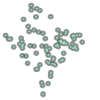

In [7]:
plants['geometry'] = plants.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
plant_states = set(plants['State'])
plant_shapes = cascaded_union(plants['geometry'])
plant_shapes

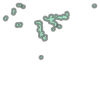

In [8]:
mines['geometry'] = mines.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
mine_states = set(mines['State']) - set(['Madhya Pradesh / Uttar Pradesh', 'Uttar Pradesh / Madhya Pradesh'])
mine_shapes = cascaded_union(mines['geometry'])
mine_shapes

In [ ]:
# all_states = plant_states.union(mine_states)
# all_shapes = cascaded_union(plants['geometry'].append(mines['geometry']))
# all_shapes

In [28]:
os.chdir('../shapes')
transmission = gpd.read_file('transmission.shp')
# substations = cascaded_union(substations['geometry'])
transmission

,index,geometry
0,0,"LINESTRING (79.23468 28.35852, 79.25588 28.59829)"
1,1,"LINESTRING (85.24640 20.17309, 85.90293 21.11521)"
2,2,"LINESTRING (79.73735 26.52196, 79.99100 26.468..."
3,3,"LINESTRING (77.69601 28.87385, 77.48206 28.89650)"
4,4,"LINESTRING (83.89794 24.98201, 83.90805 25.18300)"
...,...,...
1222,1222,"LINESTRING (77.57137 12.83264, 77.57769 12.994..."
1223,1223,"LINESTRING (77.53873 15.06312, 77.74546 14.965..."
1224,1224,"LINESTRING (77.02627 16.08207, 77.11142 15.912..."
1225,1225,"LINESTRING (77.40900 13.49273, 77.49019 13.336..."


In [20]:
polygons = {
    'plants': plant_shapes,
    'mines': mine_shapes,
}

<AxesSubplot:>

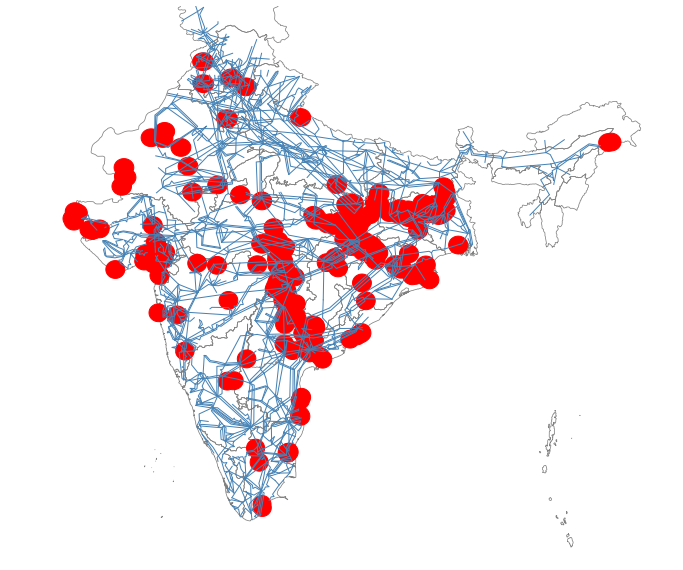

In [41]:
fig = geoplot.polyplot(
    gpd.GeoSeries(states),
    edgecolor='gray',
    figsize=(12, 12), 
    linewidth=0.75
)

geoplot.sankey(
    gpd.GeoSeries(transmission['geometry']),
    ax=fig
)

geoplot.polyplot(
    gpd.GeoSeries(polygons),
    edgecolor='red',
    facecolor='red',
    ax=fig
)

# Load Geodata MODIS Mask

In [ ]:
os.chdir('../masks')

In [ ]:
india_wind_plants = geodata.Mask("India Wind Plants", layer_path = {
    'modis': 'MODIS_INDIA_WIND.tif'
})
india_wind_mines = geodata.Mask("India Wind Mines", layer_path = {
    'modis': 'MODIS_INDIA_WIND.tif'
})
india_wind_all = geodata.Mask("India Wind All", layer_path = {
    'modis': 'MODIS_INDIA_WIND.tif'
})

india_solar_plants = geodata.Mask("India Solar Plants", layer_path = {
    'modis': 'MODIS_INDIA_SOLAR.tif'
})
india_solar_mines = geodata.Mask("India Solar Mines", layer_path = {
    'modis': 'MODIS_INDIA_SOLAR.tif'
})
india_solar_all = geodata.Mask("India Solar All", layer_path = {
    'modis': 'MODIS_INDIA_SOLAR.tif'
})

In [ ]:
# india_wind_plants.layers['modis'] = geodata.mask.binarize_raster(india_wind_plants.layers['modis'], values = [6,7,8,9,10,12,14,16])
# india_wind_mines.layers['modis'] = geodata.mask.binarize_raster(india_wind_mines.layers['modis'], values = [6,7,8,9,10,12,14,16])
# india_wind_all.layers['modis'] = geodata.mask.binarize_raster(india_wind_all.layers['modis'], values = [6,7,8,9,10,12,14,16])

# india_solar_plants.layers['modis'] = geodata.mask.binarize_raster(india_solar_plants.layers['modis'], values = [6,7,8,9,10,16])
# india_solar_mines.layers['modis'] = geodata.mask.binarize_raster(india_solar_mines.layers['modis'], values = [6,7,8,9,10,16])
# india_solar_all.layers['modis'] = geodata.mask.binarize_raster(india_solar_all.layers['modis'], values = [6,7,8,9,10,16])

In [ ]:
geodata.mask.show_all(india_solar_plants.layers)

In [ ]:
geodata.mask.show_all(india_wind_plants.layers)

# Extract Shapes as Mask Layers

In [ ]:
plant_shapes = {'coal': plant_shapes}
mine_shapes = {'coal': mine_shapes}
all_shapes = {'coal': all_shapes}

In [ ]:
india_wind_plants.extract_shapes(plant_shapes, layer = 'modis')
india_wind_mines.extract_shapes(mine_shapes, layer = 'modis')
india_wind_all.extract_shapes(all_shapes, layer = 'modis')

india_solar_plants.extract_shapes(plant_shapes, layer = 'modis')
india_solar_mines.extract_shapes(mine_shapes, layer = 'modis')
india_solar_all.extract_shapes(all_shapes, layer = 'modis')

In [ ]:
india_wind_plants.add_shape_layer({
    'coal': plant_shapes['coal']
}, reference_layer='modis')

india_wind_mines.add_shape_layer({
    'coal': mine_shapes['coal']
}, reference_layer='modis')

india_wind_all.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')


india_solar_plants.add_shape_layer({
    'coal': plant_shapes['coal']
}, reference_layer='modis')

india_solar_mines.add_shape_layer({
    'coal': mine_shapes['coal']
}, reference_layer='modis')

india_solar_all.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')

# Merge Districts + MODIS

In [ ]:
india_wind_plants.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_wind_mines.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_wind_all.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')

india_solar_plants.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_solar_mines.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_solar_all.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')

## States 

In [ ]:
india_wind_plants.extract_shapes({x: states[x] for x in plant_states if x in states.keys()})
india_wind_mines.extract_shapes({x: states[x] for x in mine_states if x in states.keys()})
india_wind_all.extract_shapes({x: states[x] for x in all_states if x in states.keys()})

india_solar_plants.extract_shapes({x: states[x] for x in plant_states if x in states.keys()})
india_solar_mines.extract_shapes({x: states[x] for x in mine_states if x in states.keys()})
india_solar_all.extract_shapes({x: states[x] for x in all_states if x in states.keys()})

In [ ]:
geodata.mask.show_all(india_wind_all.shape_mask)

In [ ]:
geodata.mask.show_all(india_solar_all.shape_mask)

# Combine Mask with Cutout

In [ ]:
india_wind_plants.save_mask()
india_wind_mines.save_mask()
india_wind_all.save_mask()

india_solar_plants.save_mask()
india_solar_mines.save_mask()
india_solar_all.save_mask()

In [ ]:
cutout.add_mask("India Wind Plants", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_plants = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind Mines", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_mines = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind All", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_all = cutout.mask(dataset = xarray_ds_wind)


cutout.add_mask("India Solar Plants", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_plants = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar Mines", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_mines = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar All", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_all = cutout.mask(dataset = xarray_ds_solar)

# Plot CF Supply Curves

In [ ]:
def make_figures(df, col, lcoe):
    df = df[df[col] > 0]
    if col == 'wind':
        df['cap'] = df['area'] * df['mask'] * 3.9 / 1000
    else:
        df['cap'] = df['area'] * df['mask'] * 27.7 / 1000
    if lcoe:
        df = df.sort_values(by = 'LCOE ($/MWh)', ascending = True)
    else:
        df = df.sort_values(by = col, ascending = False)
    df = df[df['cap'] > 0]
    df['cumsum'] = df['cap'].cumsum()
    return df.reset_index(drop=True)

def batch_figures(xr_provs, col, coal, t_30, t_47, lcoe=False):
    dfs = {xr_prov:[] for xr_prov in xr_provs}
    for xr_prov in xr_provs:
        if xr_prov != 'coal':
            df = xr_provs[xr_prov].to_dataframe().reset_index(drop=False)
            df = make_figures(df, col, lcoe)
            dfs[xr_prov] = df
    fig = go.Figure()
    if lcoe:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov]['LCOE ($/MWh)'],
                        mode='lines', 
                        name=xr_prov,
                        showlegend=True
                    )
                )
        fig.update_layout(
            title="{} LCOE Supply Curves near Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="LCOE ($/MWh)",
            legend_title="Provinces",
        )
    else:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov][col],
                        mode='lines', 
                        name=xr_prov,
                        showlegend=True
                    )
                )      
        fig.update_layout(
            title="{} Capacity Supply Curves near Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="Capacity Factor (%)",
            legend_title="Provinces",
        )
    fig.add_vline(
        x=sum(t_30.values()),
        annotation_text="Target 2030: {} GW".format(round(sum(t_30.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=sum(t_47.values()),
        annotation_text="Target 2047: {} GW".format(round(sum(t_47.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
        
    fig.show()

    return dfs

## Capacity Supply Curves

### Solar

In [ ]:
plant_solar_dfs = batch_figures(combine_solar_plants, 'solar', 'Plants', solar_t_30, solar_t_47)

In [ ]:
mine_solar_dfs = batch_figures(combine_solar_mines, 'solar', 'Mines', solar_t_30, solar_t_47)

In [ ]:
all_solar_dfs = batch_figures(combine_solar_all, 'solar', 'Plants+Mines', solar_t_30, solar_t_47)

### Wind

In [ ]:
plant_wind_dfs = batch_figures(combine_wind_plants, 'wind', 'Plants', wind_t_30, wind_t_47)

In [ ]:
mine_wind_dfs = batch_figures(combine_wind_mines, 'wind', 'Mines', wind_t_30, wind_t_47)

In [ ]:
all_wind_dfs = batch_figures(combine_wind_all, 'wind', 'Plants+Mines', wind_t_30, wind_t_47)

## LCOE Supply Curves

### Solar

In [ ]:
plant_solar_dfs_lcoe = batch_figures(combine_solar_plants, 'solar', 'Plants', solar_t_30, solar_t_47, True)

In [ ]:
mine_solar_dfs_lcoe = batch_figures(combine_solar_mines, 'solar', 'Mines', solar_t_30, solar_t_47, True)

In [ ]:
all_solar_dfs_lcoe = batch_figures(combine_solar_all, 'solar', 'Plants+Mines', solar_t_30, solar_t_47, True)

### Wind

In [ ]:
plant_wind_dfs_lcoe = batch_figures(combine_wind_plants, 'wind', 'Plants', wind_t_30, wind_t_47, True)

In [ ]:
mine_wind_dfs_lcoe = batch_figures(combine_wind_mines, 'wind', 'Mines', wind_t_30, wind_t_47, True)

In [ ]:
all_wind_dfs_lcoe = batch_figures(combine_wind_all, 'wind', 'Plants+Mines', wind_t_30, wind_t_47, True)

# Plot Figures by State

In [ ]:
def plot_fig_state(restricted_dfs, col, state, level, t_30, t_47, lcoe=False):
    fig = go.Figure()
    df = restricted_dfs[state]
    df_30 = df[df['cumsum'] <= t_30[state]]
    df_47 = df[df['cumsum'] <= t_47[state]]
    avg_30 = np.nan
    avg_47 = np.nan
    if lcoe: 
        if sum(df_30['cap']) > 0 and sum(df_47['cap']) > 0:
            avg_30 = round(sum(df_30['cap'] * df_30['LCOE ($/MWh)']) / sum(df_30['cap']), 2)        
            avg_47 = round(sum(df_47['cap'] * df_47['LCOE ($/MWh)']) / sum(df_47['cap']), 2)
            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state]['LCOE ($/MWh)'],
                    name='Restricted Case')
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean LCOE 2030: {} $/MWh".format(avg_30),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean LCOE 2047: {} $/MWh".format(avg_47),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} LCOE Supply Curves in Provinces with Coal {} in {}".format(col.capitalize(), level, state),
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="LCOE ($/MWh)",
                legend_title="Province",
            )
            if col == 'wind':
                fig.update_yaxes(
                    range=(40, 80)
                )
    else:
        if sum(df_30['cap']) > 0 and sum(df_47['cap']) > 0:
            avg_30 = round(sum(df_30['cap'] * df_30[col]) / sum(df_30['cap']), 4)        
            avg_47 = round(sum(df_47['cap'] * df_47[col]) / sum(df_47['cap']), 4)

            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state][col], 
                    name='Restricted Case')
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean CF 2030: {}".format(avg_30),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean CF 2047: {}".format(avg_47),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} Capacity Supply Curves in Provinces with Coal {} in {}".format(col.capitalize(), level, state),            
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="Capacity Factor (%)",
                legend_title="Province",
            )
    fig.add_vline(
        x=t_30[state],
        annotation_text="Target 2030: {} GW".format(round(t_30[state], 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=t_47[state],
        annotation_text="Target 2047: {} GW".format(round(t_47[state], 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    if len(restricted_dfs[state]['cumsum']) > 0:
        fig.update_xaxes(
            range=(restricted_dfs[state]['cumsum'][0], 55)
        )
    fig.show()
    return round(avg_30, 2), round(avg_47, 2)

## Capacity Supply Curves

### Solar

In [ ]:
plot_fig_state(plant_solar_dfs, 'solar', 'Gujarat', 'Plants', solar_t_30, solar_t_47)

In [ ]:
plot_fig_state(mine_solar_dfs, 'solar', 'Gujarat', 'Mines', solar_t_30, solar_t_47)

In [ ]:
plot_fig_state(all_solar_dfs, 'solar', 'Gujarat', 'Plants+Mines', solar_t_30, solar_t_47)

### Wind

In [ ]:
plot_fig_state(plant_wind_dfs, 'wind', 'Gujarat', 'Plants', wind_t_30, wind_t_47)

In [ ]:
plot_fig_state(mine_wind_dfs, 'wind', 'Gujarat', 'Mines', wind_t_30, wind_t_47)

In [ ]:
plot_fig_state(all_wind_dfs, 'wind', 'Gujarat', 'Plants+Mines', wind_t_30, wind_t_47)

## LCOE Supply Curves

### Solar

In [ ]:
plot_fig_state(plant_solar_dfs_lcoe, 'solar', 'Gujarat', 'Plants', solar_t_30, solar_t_47, True)

In [ ]:
plot_fig_state(mine_solar_dfs_lcoe, 'solar', 'Gujarat', 'Mines', solar_t_30, solar_t_47, True)

In [ ]:
plot_fig_state(all_solar_dfs_lcoe, 'solar', 'Gujarat', 'Plants+Mines', solar_t_30, solar_t_47, True)

### Wind

In [ ]:
plot_fig_state(plant_wind_dfs_lcoe, 'wind', 'Gujarat', 'Plants', wind_t_30, wind_t_47, True)

In [ ]:
plot_fig_state(mine_wind_dfs_lcoe, 'wind', 'Gujarat', 'Mines', wind_t_30, wind_t_47, True)

In [ ]:
plot_fig_state(all_wind_dfs_lcoe, 'wind', 'Gujarat', 'Plants+Mines', wind_t_30, wind_t_47, True)

# Get State Averages

In [ ]:
plants

In [ ]:
states = set(np.unique(mines['State, Province'])).intersection(set(np.unique(plants['State'])))

In [ ]:
averages_2030 = {state: [] for state in states if solar_t_30[state] > 0 or wind_t_30[state] > 0}
averages_2047 = {state: [] for state in states if solar_t_47[state] > 0 or wind_t_47[state] > 0}

for state in states:
    wind_all_avg_CF = plot_fig_state(all_wind_dfs, 'wind', state, 'Plants+Mines', wind_t_30, wind_t_47)
    wind_all_avg_LCOE = plot_fig_state(all_wind_dfs_lcoe, 'wind', state, 'Plants+Mines', wind_t_30, wind_t_47, True)
    solar_all_avg_CF = plot_fig_state(all_solar_dfs, 'solar', state, 'Plants+Mines', solar_t_30, solar_t_47)
    solar_all_avg_LCOE = plot_fig_state(all_solar_dfs_lcoe, 'solar', state, 'Plants+Mines', solar_t_30, solar_t_47, True)

    averages_2030[state] = [wind_all_avg_CF[0], wind_all_avg_LCOE[0], solar_all_avg_CF[0], solar_all_avg_LCOE[0]]
    averages_2047[state] = [wind_all_avg_CF[1], wind_all_avg_LCOE[1], solar_all_avg_CF[1], solar_all_avg_LCOE[1]]

In [ ]:
# make pivot tables
pivot_2030 = pd.DataFrame(averages_2030).T
pivot_2030.columns = ['wind_all_avg_CF', 'wind_all_avg_LCOE', 'solar_all_avg_CF', 'solar_all_avg_LCOE']

pivot_2047 = pd.DataFrame(averages_2047).T
pivot_2047.columns = ['wind_all_avg_CF', 'wind_all_avg_LCOE', 'solar_all_avg_CF', 'solar_all_avg_LCOE']

In [ ]:
# # break down into smaller dataframes
cf_summary_30 = pivot_2030[['wind_all_avg_CF', 'solar_all_avg_CF']]
cf_summary_30.columns = ['Wind', 'Solar']
lcoe_summary_30 = pivot_2030[['wind_all_avg_LCOE', 'solar_all_avg_LCOE']]
lcoe_summary_30.columns = ['Wind', 'Solar']

cf_summary_47 = pivot_2047[['wind_all_avg_CF', 'solar_all_avg_CF']]
cf_summary_47.columns = ['Wind', 'Solar']
lcoe_summary_47 = pivot_2047[['wind_all_avg_LCOE', 'solar_all_avg_LCOE']]
lcoe_summary_47.columns = ['Wind', 'Solar']

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State CFs for Wind and Solar in 2030")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State LCOE ($/MWh) for Wind and Solar in 2030")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State CFs for Wind and Solar in 2047")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State LCOE ($/MWh) for Wind and Solar in 2047")